# Metocean Data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import xarray as xr
import distributed

In [3]:
client = distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:58768 Dashboard: http://127.0.0.1:58769,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


# CANADIAN DATA

## GIOPS

http://dd.weather.gc.ca/model_giops/doc/README_GIOPS.txt

## RIOPS

In [53]:
ds = xr.open_dataset('http://navigator.oceansdata.ca/thredds/dodsC/riops/riopsf/2016091918_006_3D_nps.nc',
                       chunks={'depth':1, 'yc':200, 'xc':200})

In [61]:
ncfiles = ['http://navigator.oceansdata.ca/thredds/dodsC/riops/riopsf/2016091906_006_3D_nps.nc',
           'http://navigator.oceansdata.ca/thredds/dodsC/riops/riopsf/2016091912_006_3D_nps.nc',
           'http://navigator.oceansdata.ca/thredds/dodsC/riops/riopsf/2016091918_006_3D_nps.nc']

In [66]:
ds = xr.open_mfdataset(ncfiles, chunks={'depth':10, 'yc':400, 'xc':400})

In [67]:
ds.vomecrty

<xarray.DataArray 'vomecrty' (time: 3, depth: 50, yc: 1610, xc: 1770)>
dask.array<shape=(3, 50, 1610, 1770), dtype=float64, chunksize=(1, 10, 400, 400)>
Coordinates:
  * xc         (xc) float32 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 ...
  * yc         (yc) float32 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 ...
  * depth      (depth) float32 0.494025 1.54138 2.64567 3.81949 5.07822 ...
    latitude   (yc, xc) float32 30.5603 30.5831 30.6058 30.6285 30.6512 ...
    longitude  (yc, xc) float32 221.282 221.315 221.348 221.381 221.414 ...
  * time       (time) datetime64[ns] 2016-09-19T12:00:00 2016-09-19T18:00:00 ...
Attributes:
    units:          m s-1
    valid_min:      -20.0
    valid_max:      20.0
    long_name:      Sea water y velocity
    short_name:     vomecrty
    standard_name:  sea_water_y_velocity
    cell_methods:   time: mean (interval: 3 hours)
    grid_mapping:   polar_stereographic
    nomvar:         VVW
    stdscale:       1.0
    stdoffset:      0.0
    _ChunkSi

In [68]:
vx = ds.vozocrtx.isel(depth=0).sel(xc=slice(6e6-1, 8e6-1),
                              yc=slice(2e6-1, 4e6-1))
vy = ds.vomecrty.isel(depth=0).sel(xc=slice(6e6-1, 8e6-1),
                              yc=slice(2e6-1, 4e6-1))

In [69]:
v = np.sqrt(vx**2+vy**2)

In [70]:
v

<xarray.DataArray (time: 3, yc: 400, xc: 400)>
array([[[      nan,       nan, ...,  0.247111,  0.242416],
        [      nan,       nan, ...,  0.251615,  0.247203],
        ..., 
        [      nan,       nan, ...,  0.06818 ,  0.076999],
        [      nan,       nan, ...,  0.06884 ,  0.072962]],

       [[      nan,       nan, ...,  0.240827,  0.240212],
        [      nan,       nan, ...,  0.247708,  0.245905],
        ..., 
        [      nan,       nan, ...,  0.142522,  0.127183],
        [      nan,       nan, ...,  0.150291,  0.132857]],

       [[      nan,       nan, ...,  0.116144,  0.105378],
        [      nan,       nan, ...,  0.121407,  0.109261],
        ..., 
        [      nan,       nan, ...,  0.070942,  0.096911],
        [      nan,       nan, ...,  0.07301 ,  0.095545]]])
Coordinates:
  * xc         (xc) float32 6e+06 6.005e+06 6.01e+06 6.015e+06 6.02e+06 ...
  * yc         (yc) float32 2e+06 2.005e+06 2.01e+06 2.015e+06 2.02e+06 ...
    depth      float32 0.494025


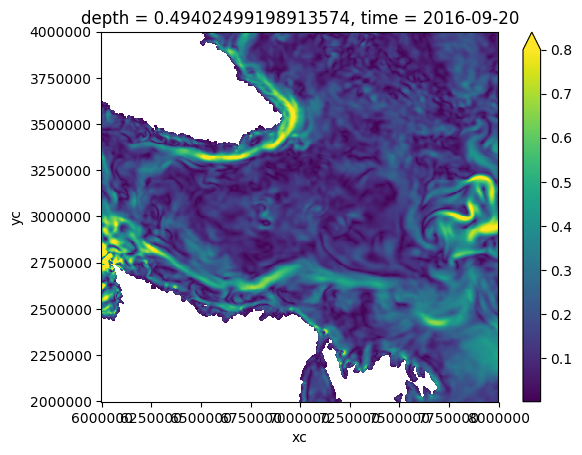

In [73]:
v.isel(time=2).plot(vmax=0.8)

In [19]:
ds.latitude.sel(xc=slice(6e6, 8e6), yc=slice(2e6, 4e6))

<xarray.DataArray 'latitude' (yc: 401, xc: 401)>
[160801 values with dtype=float32]
Coordinates:
  * xc         (xc) float32 6e+06 6.005e+06 6.01e+06 6.015e+06 6.02e+06 ...
  * yc         (yc) float32 2e+06 2.005e+06 2.01e+06 2.015e+06 2.02e+06 ...
    latitude   (yc, xc) float32 ...
    longitude  (yc, xc) float32 ...
Attributes:
    valid_min:      -90.0
    valid_max:      90.0
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north
    _ChunkSizes:    [805 885]

# AMERICAN DATA

## NOMADS - GFS

- 3 hour

In [18]:
gfs_url ='https://www.ncei.noaa.gov/thredds/dodsC/gfs-g4-anl-files/201512/20151231/gfsanl_4_20151231_1800_006.grb2'

In [19]:
gfs_ds = xr.open_dataset(gfs_url)

In [65]:
gfs_ds

<xarray.Dataset>
Dimensions:                                                                   (altitude_above_msl: 3, depth_below_surface_layer: 4, depth_below_surface_layer_bounds_1: 2, height_above_ground: 1, height_above_ground1: 2, height_above_ground2: 1, height_above_ground3: 3, height_above_ground4: 3, height_above_ground_layer: 1, height_above_ground_layer1: 1, height_above_ground_layer1_bounds_1: 2, height_above_ground_layer_bounds_1: 2, isobaric: 12, isobaric1: 1, isobaric2: 21, isobaric3: 26, lat: 361, lon: 720, potential_vorticity_surface: 2, pressure_difference_layer: 1, pressure_difference_layer1: 1, pressure_difference_layer1_bounds_1: 2, pressure_difference_layer2: 2, pressure_difference_layer2_bounds_1: 2, pressure_difference_layer_bounds_1: 2, sigma: 1, sigma_layer: 4, sigma_layer_bounds_1: 2, time: 1, time1: 1, time_bounds_1: 2)
Coordinates:
  * lat                                                                       (lat) float32 90.0 ...
  * lon                  

In [70]:
u_wind = gfs_ds.__getitem__('u-component_of_wind_height_above_ground')
v_wind = gfs_ds.__getitem__('v-component_of_wind_height_above_ground')

In [74]:
u_wind.dims

('time1', 'height_above_ground3', 'lat', 'lon')

## NOMADS RTOFS

- 1 hour

http://polar.ncep.noaa.gov/mmab/papers/tn284/v211p211.pdf

https://data.nodc.noaa.gov/thredds/catalog/ncep/rtofs/catalog.html

In [6]:
rotfs_url = 'https://data.nodc.noaa.gov/thredds/dodsC/ncep/rtofs/2015/201512/ofs.20151231/surface/ofs_atl.t00z.n000.20151231.grb.grib2'

In [8]:
rotfs_ds = xr.open_dataset(rotfs_url)

In [85]:
rotfs_ds.y

<xarray.DataArray 'y' (y: 1684)>
array([   0,    1,    2, ..., 1681, 1682, 1683])
Dimensions without coordinates: y

In [71]:
v_current = rotfs_ds.__getitem__('V-component_of_current')
u_current = rotfs_ds.__getitem__('U-component_of_current')
n3d_temperature = rotfs_ds.__getitem__('N3-D_Temperature')

In [72]:
v_current.dims

('time', 'hybrid_layer', 'y', 'x')

In [81]:
n3d_temperature.dims

('time', 'hybrid_layer', 'y', 'x')

### Convert lon, lat to x, y

### Old Examples

In [6]:
ds = xr.open_dataset('http://nomads.ncep.noaa.gov:9090/dods/rtofs/rtofs_global20180111/rtofs_glo_2ds_forecast_3hrly_diag',
                       chunks={'lat':400, 'lon':400, 'time':10})

In [12]:
ds

<xarray.Dataset>
Dimensions:        (lat: 2160, lev: 1, lon: 4320, time: 65)
Coordinates:
  * time           (time) datetime64[ns] 2018-01-11 2018-01-11T03:00:00 ...
  * lev            (lev) float64 1.0
  * lat            (lat) float64 -90.0 -89.92 -89.83 -89.75 -89.67 -89.58 ...
  * lon            (lon) float64 74.16 74.24 74.33 74.41 74.49 74.58 74.66 ...
Data variables:
    ssh            (time, lev, lat, lon) float64 dask.array<shape=(65, 1, 2160, 4320), chunksize=(10, 1, 400, 400)>
    ice_coverage   (time, lev, lat, lon) float64 dask.array<shape=(65, 1, 2160, 4320), chunksize=(10, 1, 400, 400)>
    ice_thickness  (time, lev, lat, lon) float64 dask.array<shape=(65, 1, 2160, 4320), chunksize=(10, 1, 400, 400)>
Attributes:
    title:        2D Sfc 3 Hourly Diagnostic 00Z11jan2018: Forecast, download...
    Conventions:  COARDS\nGrADS
    dataType:     Grid
    history:      Fri Jan 12 11:13:56 UTC 2018 : imported by GrADS Data Serve...

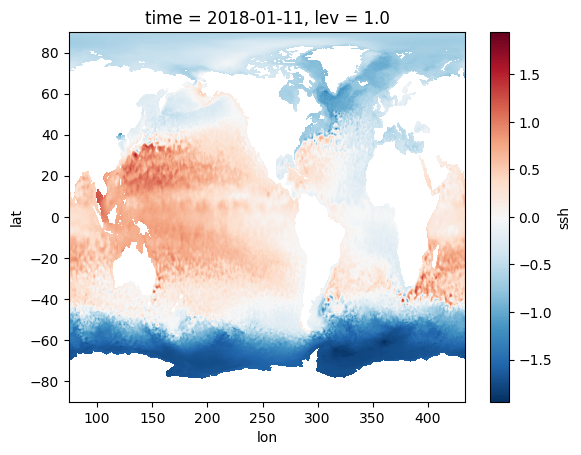

In [10]:
ds.ssh.isel(time=0).plot()